In [1]:
!pip install -e /dss/dsshome1/04/di93zer/git/cellnet --no-deps

Obtaining file:///dss/dsshome1/04/di93zer/git/cellnet
  Preparing metadata (setup.py) ... done
  Running setup.py develop for cellnet

[notice] A new release of pip is available: 23.1.1 -> 23.1.2
[notice] To update, run: python3 -m pip install --upgrade pip


# Visualize training dynamics

In [1]:
import os
import re
from os.path import join

import tensorboard as tb
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# logs under: https://tensorboard.dev/experiment/Mwv9MtgKTmWi3GFA4yaPbA/#scalars
experiment_id = 'Mwv9MtgKTmWi3GFA4yaPbA'
experiment = tb.data.experimental.ExperimentFromDev(experiment_id)
df = experiment.get_scalars()

In [3]:
LOGS_PATH = '/mnt/dssfs02/tb_logs/juwles/cxg_2023_05_15_tabnet/default'

AUGMENTED = [
    ['version_9', 'version_9_cont'],
    ['version_10', 'version_10_cont'],
    ['version_11', 'version_11_cont'],
    ['version_12', 'version_12_cont'],
]
NON_AUGMENTED = [
    ['version_13', 'version_13_cont'],
    ['version_14', 'version_14_cont'],
    ['version_15', 'version_15_cont'],
    ['version_16', 'version_16_cont'],
]

In [4]:
def get_data(data, versions, columns):
    dfs = []
    for version in versions:
        if isinstance(version, str):
            version = [version]
        dfs.append(
            data[data.run.isin(version)]
            .drop_duplicates(subset=['step', 'tag'], keep='last')
            .pivot(index='step', columns='tag', values='value')
            [columns]
            .dropna()
            .assign(version=version[0])
        )
        
    return pd.concat(dfs)


val_cols = ['epoch', 'val_loss', 'val_f1_macro', 'val_f1_micro']
df_val_augmented = get_data(df, AUGMENTED, val_cols).assign(data_augmentation=True)
df_val_non_augmented = get_data(df, NON_AUGMENTED, val_cols).assign(data_augmentation=False)

train_cols = ['epoch', 'train_loss']
df_train_augmented = get_data(df, AUGMENTED, train_cols).assign(data_augmentation=True).reset_index()
df_train_non_augmented = get_data(df, NON_AUGMENTED, train_cols).assign(data_augmentation=False).reset_index()

In [6]:
def get_best_ckpts(logs_path, versions):
    epochs = []
    best_ckpts = []
    
    for version in versions:
        version = version[-1]
        # sort first -> in case both f1-score are the same -> take the one which was trained for less epochs
        files = sorted([file for file in os.listdir(join(logs_path, version, 'checkpoints')) if 'val_f1_macro' in file])
        f1_scores = [float(re.search('val_f1_macro=(.*?).ckpt', file).group(1)) for file in files]
        best_ckpt = files[np.argmax(f1_scores)]
        epochs.append(int(re.search('epoch=(.*?)_val_f1_macro', best_ckpt).group(1)))
        best_ckpts.append(best_ckpt)

    return best_ckpts, np.mean(epochs)


best_ckpts_augmented, avg_train_time_augmented = get_best_ckpts(LOGS_PATH, AUGMENTED)
best_ckpts_non_augmented, avg_train_time_non_augmented = get_best_ckpts(LOGS_PATH, NON_AUGMENTED)

#### Validation metrics

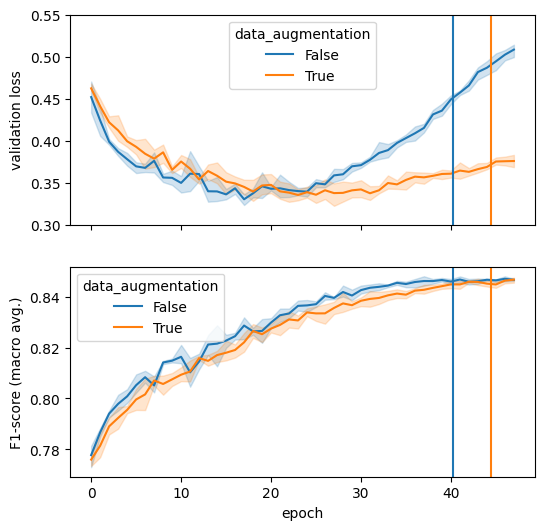

In [7]:
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(6, 6))

sns.lineplot(x='epoch', y='val_loss', hue='data_augmentation', data=pd.concat([df_val_augmented, df_val_non_augmented]), ax=axs[0])
axs[0].set_ylabel('validation loss')
axs[0].set_ylim(0.3, 0.55)
axs[0].axvline(avg_train_time_augmented, color='#ff7f0e')
axs[0].axvline(avg_train_time_non_augmented, color='#1f77b4')

sns.lineplot(x='epoch', y='val_f1_macro', hue='data_augmentation', data=pd.concat([df_val_augmented, df_val_non_augmented]), ax=axs[1])
axs[1].set_ylabel('F1-score (macro avg.)')
axs[1].axvline(avg_train_time_augmented, color='#ff7f0e')
axs[1].axvline(avg_train_time_non_augmented, color='#1f77b4');

#### Training metrics

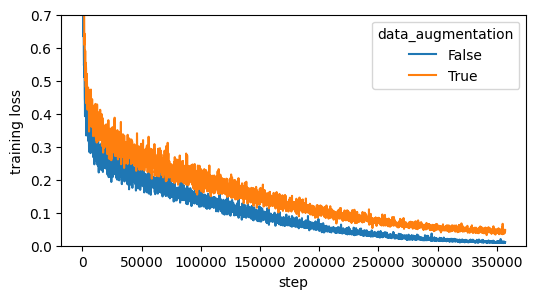

In [24]:
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(6, 3))

ax = sns.lineplot(
    x='step', y='train_loss', hue='data_augmentation', 
    errorbar=None,
    data=pd.concat([df_train_augmented, df_train_non_augmented]))
ax.set_ylabel('training loss')
ax.set_ylim(0.0, 0.7);

# Evaluate performance

In [9]:
import torch
torch.set_float32_matmul_precision('high')

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
from os.path import join

import numpy as np
import pandas as pd
import lightning.pytorch as pl
import dask.dataframe as dd

from cellnet.estimators import EstimatorCellTypeClassifier
from cellnet.models import TabnetClassifier

/usr/local/lib/python3.8/dist-packages/merlin/dtypes/mappings/tf.py:52: UserWarning: Tensorflow dtype mappings did not load successfully due to an error: No module named 'tensorflow'
  warn(f"Tensorflow dtype mappings did not load successfully due to an error: {exc.msg}")


In [11]:
DATA_PATH = '/mnt/dssmcmlfs01/merlin_cxg_2023_05_15_sf-log1p'

In [12]:
import gc


def evaluate(ckpts):
    estim = EstimatorCellTypeClassifier(DATA_PATH)
    estim.init_datamodule(batch_size=2048)
    estim.trainer = pl.Trainer(logger=[], accelerator='gpu', devices=1)
    
    results = {'test_loss': [], 'test_f1_macro': [], 'test_f1_micro': []}
    for ckpt in ckpts:
        estim.model = TabnetClassifier.load_from_checkpoint(ckpt, **estim.get_fixed_model_params('tabnet'))
        res = estim.test()[0]
        results['test_loss'].append(res['test_loss'])
        results['test_f1_macro'].append(res['test_f1_macro'])
        results['test_f1_micro'].append(res['test_f1_micro'])

    return results


In [16]:
ckpts_path_augmented = [
    join(LOGS_PATH, version[-1], 'checkpoints', best_ckpt) 
    for version, best_ckpt in zip(AUGMENTED, best_ckpts_augmented)
]
ckpts_path_non_augmented = [
    join(LOGS_PATH, version[-1], 'checkpoints', best_ckpt) 
    for version, best_ckpt in zip(NON_AUGMENTED, best_ckpts_non_augmented)
]

In [25]:
scores_augment = evaluate(ckpts_path_augmented)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: SLURM auto-requeueing enabled. Setting signal handlers.
INFO:lightning.pytorch.trainer.connectors.signal_connector:SLURM auto-requeueing enabled. Setting signal handlers.


Testing DataLoader 0: 100%|██████████| 1684/1684 [07:52<00:00,  3.56it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_f1_macro       │    0.8293573260307312     │
│       test_f1_micro       │    0.9070702791213989     │
│         test_loss         │    0.46727797389030457    │
└───────────────────────────┴───────────────────────────┘

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: SLURM auto-requeueing enabled. Setting signal handlers.
INFO:lightning.pytorch.trainer.connectors.signal_connector:SLURM auto-requeueing enabled. Setting signal handlers.


Testing DataLoader 0: 100%|██████████| 1684/1684 [07:51<00:00,  3.57it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_f1_macro       │    0.8299700021743774     │
│       test_f1_micro       │    0.9083741903305054     │
│         test_loss         │    0.47546783089637756    │
└───────────────────────────┴───────────────────────────┘

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: SLURM auto-requeueing enabled. Setting signal handlers.
INFO:lightning.pytorch.trainer.connectors.signal_connector:SLURM auto-requeueing enabled. Setting signal handlers.


Testing DataLoader 0: 100%|██████████| 1684/1684 [07:51<00:00,  3.57it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_f1_macro       │    0.8312424421310425     │
│       test_f1_micro       │    0.9089570045471191     │
│         test_loss         │    0.47564467787742615    │
└───────────────────────────┴───────────────────────────┘

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: SLURM auto-requeueing enabled. Setting signal handlers.
INFO:lightning.pytorch.trainer.connectors.signal_connector:SLURM auto-requeueing enabled. Setting signal handlers.


Testing DataLoader 0: 100%|██████████| 1684/1684 [07:55<00:00,  3.54it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_f1_macro       │    0.8288002014160156     │
│       test_f1_micro       │    0.9061946272850037     │
│         test_loss         │    0.45885464549064636    │
└───────────────────────────┴───────────────────────────┘

In [18]:
scores_non_augment = evaluate(ckpts_path_non_augmented)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: SLURM auto-requeueing enabled. Setting signal handlers.
INFO:lightning.pytorch.trainer.connectors.signal_connector:SLURM auto-requeueing enabled. Setting signal handlers.


Testing DataLoader 0: 100%|██████████| 1684/1684 [07:52<00:00,  3.56it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_f1_macro       │    0.8292769193649292     │
│       test_f1_micro       │     0.907283365726471     │
│         test_loss         │    0.5671480298042297     │
└───────────────────────────┴───────────────────────────┘

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: SLURM auto-requeueing enabled. Setting signal handlers.
INFO:lightning.pytorch.trainer.connectors.signal_connector:SLURM auto-requeueing enabled. Setting signal handlers.


Testing DataLoader 0: 100%|██████████| 1684/1684 [07:53<00:00,  3.56it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_f1_macro       │    0.8304275870323181     │
│       test_f1_micro       │     0.907927930355072     │
│         test_loss         │    0.6064368486404419     │
└───────────────────────────┴───────────────────────────┘

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: SLURM auto-requeueing enabled. Setting signal handlers.
INFO:lightning.pytorch.trainer.connectors.signal_connector:SLURM auto-requeueing enabled. Setting signal handlers.


Testing DataLoader 0: 100%|██████████| 1684/1684 [07:53<00:00,  3.56it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_f1_macro       │    0.8314728736877441     │
│       test_f1_micro       │     0.908397376537323     │
│         test_loss         │    0.5860649943351746     │
└───────────────────────────┴───────────────────────────┘

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: SLURM auto-requeueing enabled. Setting signal handlers.
INFO:lightning.pytorch.trainer.connectors.signal_connector:SLURM auto-requeueing enabled. Setting signal handlers.


Testing DataLoader 0: 100%|██████████| 1684/1684 [07:52<00:00,  3.56it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_f1_macro       │    0.8304101228713989     │
│       test_f1_micro       │    0.9079117178916931     │
│         test_loss         │    0.6524209976196289     │
└───────────────────────────┴───────────────────────────┘

#### Summary

In [19]:
from statistics import mean, stdev
from scipy.stats import ttest_ind

In [26]:
pd.DataFrame({
    'Neg. log-likelihood': [
        f"{mean(scores_augment['test_loss']):.3} +/- {stdev(scores_augment['test_loss']):.1}", 
        f"{mean(scores_non_augment['test_loss']):.3} +/- {stdev(scores_non_augment['test_loss']):.1}"
    ],
    'F1-score (macro avg.)': [
        f"{mean(scores_augment['test_f1_macro']):.4} +/- {stdev(scores_augment['test_f1_macro']):.1}",
        f"{mean(scores_non_augment['test_f1_macro']):.4} +/- {stdev(scores_non_augment['test_f1_macro']):.1}"
    ]
}, index=['w. augmentation', 'wo. augmentation'])

,Neg. log-likelihood,F1-score (macro avg.)
w. augmentation,0.469 +/- 0.008,0.8298 +/- 0.001
wo. augmentation,0.603 +/- 0.04,0.8304 +/- 0.0009


In [21]:
from IPython.display import display
pd.options.display.float_format = None

In [27]:
pct_change_loss = 1. - mean(scores_non_augment['test_loss']) / mean(scores_augment['test_loss'])
pct_change_f1 = 1. - mean(scores_non_augment['test_f1_macro']) / mean(scores_augment['test_f1_macro'])


pd.DataFrame({
    'Neg. log-likelihood': [
        f'{pct_change_loss * 100.:.3}%',
        ttest_ind(scores_non_augment['test_loss'], scores_augment['test_loss']).pvalue,
        ttest_ind(scores_non_augment['test_loss'], scores_augment['test_loss']).pvalue <= 0.05
    ],
    'F1-score (macro avg.)': [
        f'{pct_change_f1 * 100.:.2}%',
        ttest_ind(scores_non_augment['test_f1_macro'], scores_augment['test_f1_macro']).pvalue,
        ttest_ind(scores_non_augment['test_f1_macro'], scores_augment['test_f1_macro']).pvalue <= 0.05
    ],
}, index=['percentage change', 'p value', 'significant'])

,Neg. log-likelihood,F1-score (macro avg.)
percentage change,-28.5%,-0.067%
p value,0.000383,0.452279
significant,True,False
